In [1]:
from plotnine import *
import pandas as pd
import wandb
api = wandb.Api()

model_sizes = {
    'resnet20': 0.27,
    'resnet32': 0.46,
    'resnet44': 0.66,
    'resnet56': 0.85,
    'resnet80': 1.25,
    'resnet110': 1.7,
}

wandb: Currently logged in as: eb4727 (eb4727-nyu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [2]:
ENTITY = "eb4727-nyu"
PROJECT = "noise-1"

runs = api.runs(f"{ENTITY}/{PROJECT}", filters={"state": "finished", "config.n_epochs": 200})

# Collect config and training loss from each run
all_data = []
for run in runs:
    print(run)
    config = dict(run.config)
    history = run.history(keys=["train_acc", "val_acc"])

    # Add run info to the history dataframe
    history['run_id'] = run.id
    for key, value in config.items():
        history[key] = value

    all_data.append(history)

df = pd.concat(all_data, ignore_index=True)
df.head()

<Run eb4727-nyu/noise-1/0gc5ncmz (finished)>
<Run eb4727-nyu/noise-1/7s8jzdbd (finished)>
<Run eb4727-nyu/noise-1/nkpvc4af (finished)>
<Run eb4727-nyu/noise-1/4rri439w (finished)>
<Run eb4727-nyu/noise-1/i996i23q (finished)>
<Run eb4727-nyu/noise-1/d3tomrc2 (finished)>
<Run eb4727-nyu/noise-1/fy1s0mqb (finished)>
<Run eb4727-nyu/noise-1/xbwcd9gi (finished)>
<Run eb4727-nyu/noise-1/07gjqddu (finished)>
<Run eb4727-nyu/noise-1/55a03j4p (finished)>
<Run eb4727-nyu/noise-1/3mbkej0m (finished)>
<Run eb4727-nyu/noise-1/y7i7s7wt (finished)>
<Run eb4727-nyu/noise-1/ga88s6o3 (finished)>
<Run eb4727-nyu/noise-1/5ok6vhwh (finished)>
<Run eb4727-nyu/noise-1/isg4x9o2 (finished)>
<Run eb4727-nyu/noise-1/mhihi0aw (finished)>
<Run eb4727-nyu/noise-1/vl6ane2b (finished)>
<Run eb4727-nyu/noise-1/g6cr907m (finished)>
<Run eb4727-nyu/noise-1/0keuh7d4 (finished)>
<Run eb4727-nyu/noise-1/ew0d71ph (finished)>
<Run eb4727-nyu/noise-1/51krnkpz (finished)>
<Run eb4727-nyu/noise-1/9ouys7sx (finished)>
<Run eb472

,_step,train_acc,val_acc,run_id,peak_lr,momentum,n_epochs,run_name,batch_size,model_name,wandb_mode,corrupt_frac
0,0,0.367188,0.3449,0gc5ncmz,0.001,0.9,200,None,1024,resnet20,online,0.0
1,1,0.520508,0.4334,0gc5ncmz,0.001,0.9,200,None,1024,resnet20,online,0.0
2,2,0.643555,0.4877,0gc5ncmz,0.001,0.9,200,None,1024,resnet20,online,0.0
3,3,0.743164,0.6134,0gc5ncmz,0.001,0.9,200,None,1024,resnet20,online,0.0
4,4,0.746094,0.6622,0gc5ncmz,0.001,0.9,200,None,1024,resnet20,online,0.0


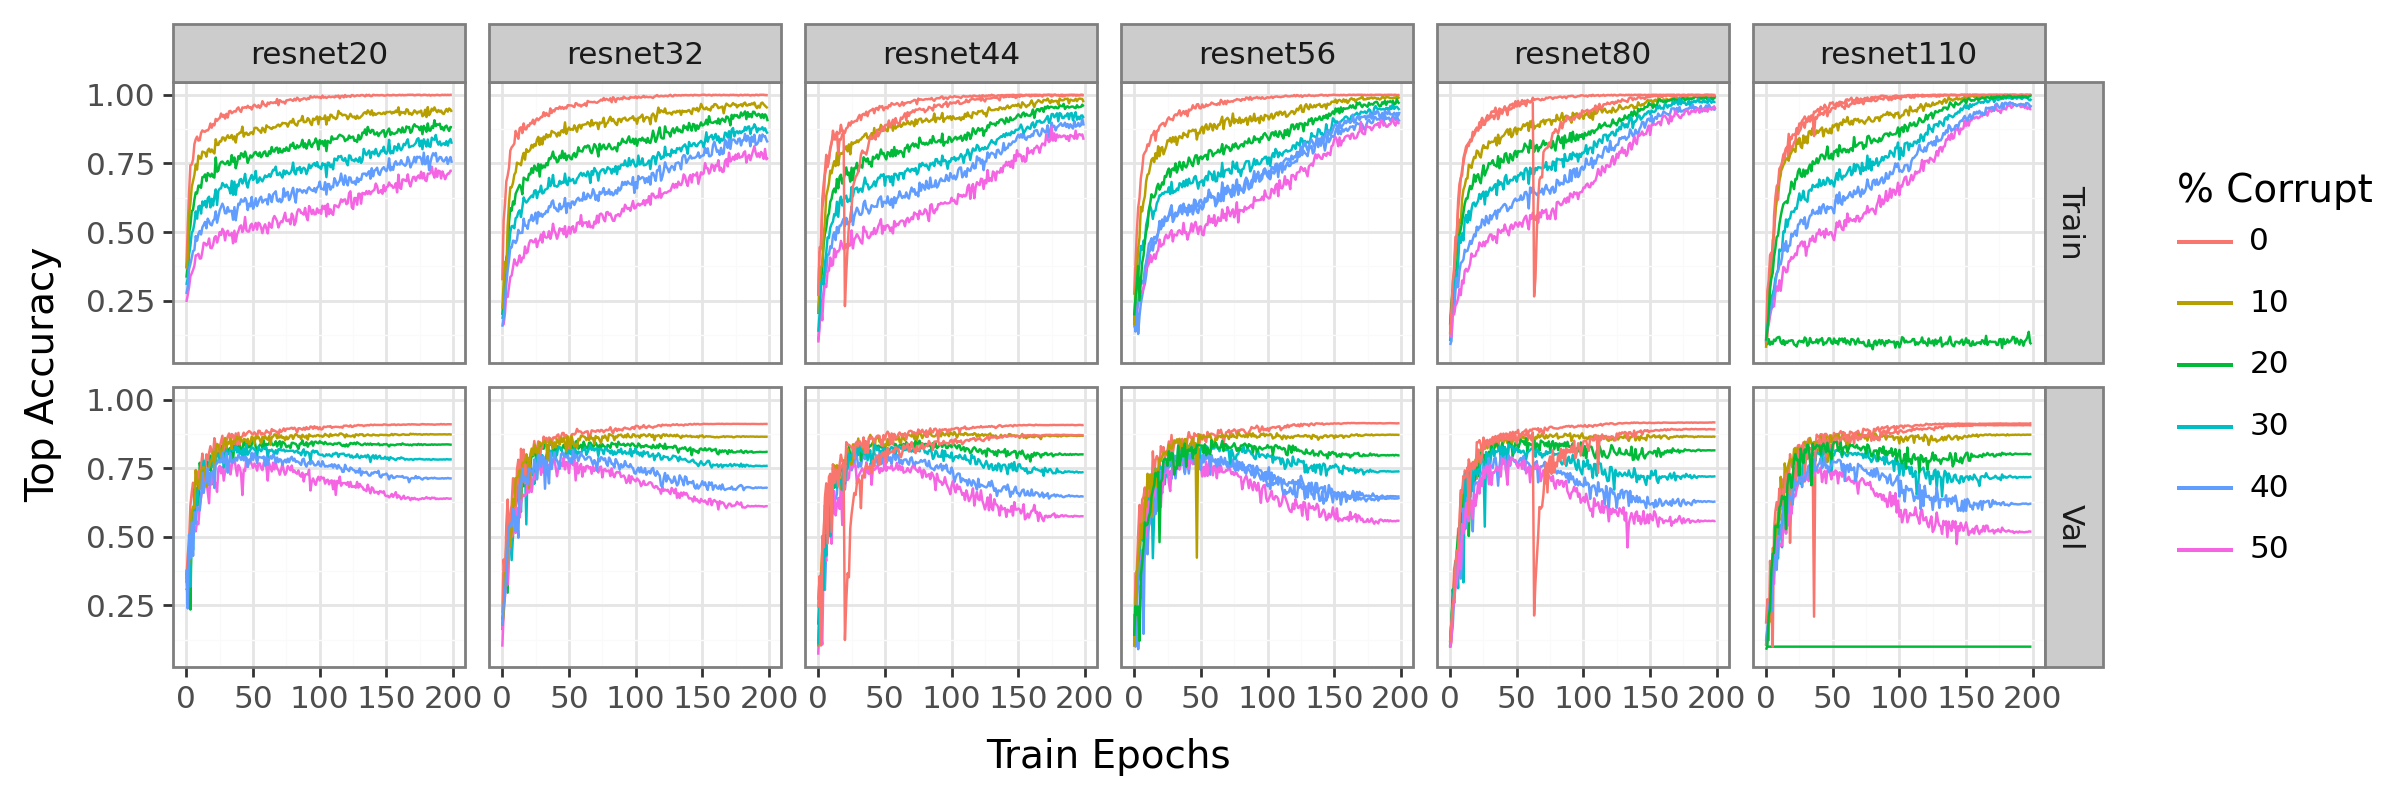

In [3]:
(
    df
    .melt(id_vars = ['_step', 'run_id', 'model_name', 'corrupt_frac'], value_vars = ['train_acc', 'val_acc'], var_name = 'dataset', value_name = 'accuracy')
    .assign(
        dataset = lambda d: d['dataset'].str.replace('_acc', '').str.capitalize(),
        model_name = lambda d: pd.Categorical(d.model_name, categories = model_sizes.keys()),
        corrupt_frac = lambda d: (d['corrupt_frac'] * 100).astype(int),
    )
    .pipe(ggplot, aes(x = "_step", y = "accuracy", color = "factor(corrupt_frac)", group = "run_id")) +
    geom_line() +
    facet_grid("dataset ~ model_name") +
    labs(x = "Train Epochs", y = "Top Accuracy", color = "% Corrupt") +
    theme_bw(base_size=14) +
    theme(figure_size=(12, 4))
)

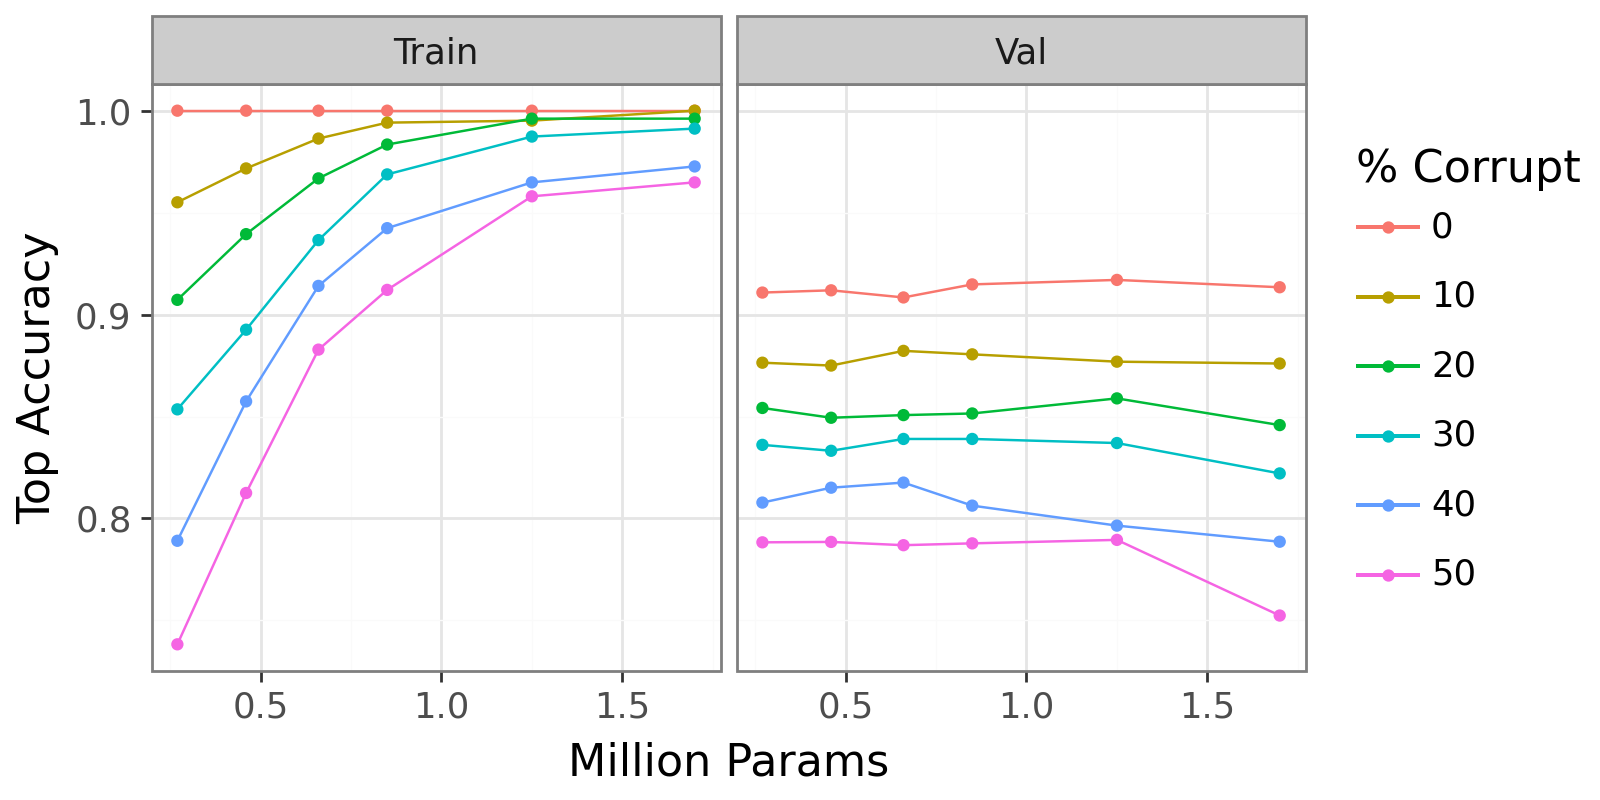

In [4]:
(
    df
    .melt(id_vars = ['_step', 'run_id', 'model_name', 'corrupt_frac'], value_vars = ['train_acc', 'val_acc'], var_name = 'dataset', value_name = 'accuracy')
    .groupby(['corrupt_frac', 'dataset', 'model_name'])['accuracy'].max()
    .reset_index()
    .assign(
        model_size = lambda d: d['model_name'].map(model_sizes),
        dataset = lambda d: d['dataset'].str.replace('_acc', '').str.capitalize(),
        corrupt_frac = lambda d: (d['corrupt_frac'] * 100).astype(int)
    )
    .query("accuracy > 0.5")
    .pipe(ggplot, aes(x = "model_size", y = "accuracy", color = "factor(corrupt_frac)")) +
    geom_line() +
    geom_point() +
    facet_grid(" ~ dataset") +
    labs(x = "Million Params", y = "Top Accuracy", color = "% Corrupt") +
    theme_bw(base_size=16) +
    theme(figure_size=(8, 4))
)